In [1]:
# 1 import package
import torch
import  torch.nn as nn
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets
from torchvision.utils import save_image
from torchvision import transforms
import os
import matplotlib.pyplot as plt

/home/waj/anaconda3/envs/tts/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
BATCH_SIZE=512
EPOCHS=200
image_size=28
channel=1
z_dim=128
device=torch.device("cuda" if torch.cuda.is_available() else "cpu" )

In [4]:
def show_mnist_image(image_array, label):
    plt.imshow(image_array, cmap='Greys')
    plt.title(f"Label: {label}")
# 1 data loader 
dataset=datasets.MNIST("../data/",train=True,transform=transforms.Compose([
    transforms.Resize(28),transforms.ToTensor(),transforms.Normalize(0.5,0.5)
]))
mnist=DataLoader(dataset,shuffle=True,batch_size=BATCH_SIZE,drop_last=True)

torch.Size([512])


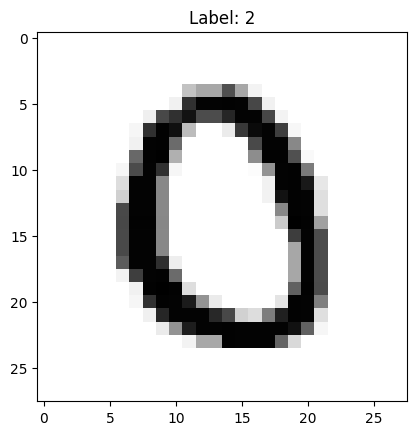

In [6]:
for data in mnist:
    print(data[1].shape)
    show_mnist_image(data[0][10][0], data[1][0])
    break

In [7]:
# 2 genreator
class Generator( nn.Module):
    def __init__(self,z_dim):
        super(Generator,self).__init__()
        self.model=nn.Sequential(nn.Linear(z_dim,128),
                      nn.ReLU(),
                      nn.Linear(128,256),
                      nn.BatchNorm1d(256),
                      nn.ReLU(),
                      nn.Linear(256,512),
                      nn.BatchNorm1d(512),
                      nn.ReLU(),
                      nn.Linear(512,1024),
                      nn.BatchNorm1d(1024),
                      nn.ReLU(),
                      nn.Linear(1024,image_size*image_size),          
                      nn.Tanh()
                     )
    def forward(self,z):
        x=self.model(z)
        return x

In [8]:
g_x=torch.randn(BATCH_SIZE,z_dim).to(device)
print(g_x.shape)

g_model=Generator(z_dim).to(device)
g_model(g_x).shape

torch.Size([512, 128])


torch.Size([512, 784])

In [9]:
# 3 diacriminator model
class Discriminator(nn.Module):
    def __init__(self,image_size):
        super(Discriminator,self).__init__()
        self.model=nn.Sequential(
            nn.Linear(image_size**2,1024),
            nn.ReLU(),
            nn.Linear(1024,256),
            nn.ReLU(),
            nn.Linear(256,64),
            nn.ReLU(),
            nn.Linear(64,1),
            nn.Sigmoid()
        
        )
    def forward(self,x):
        x=self.model(x)
        return x.reshape(-1)

In [10]:
d_model=Discriminator(28).to(device)
d_model(data[0].reshape(BATCH_SIZE,-1).to(device)).shape

torch.Size([512])

In [11]:
g_optim=torch.optim.Adam(g_model.parameters(),1e-4)
d_optim=torch.optim.Adam(d_model.parameters(),1e-4)

In [12]:
loss_fn=nn.BCELoss()

In [13]:
# 模型训练

In [14]:
index=0
for epoch in range(EPOCHS):
    for data,label in mnist:
        x=data.reshape(BATCH_SIZE,-1).to(device)
        # 5.1 生成器训练 generator
        z=torch.randn(BATCH_SIZE,z_dim).to(device)
        
        x_fake=g_model(z)
        
        ones=torch.ones(BATCH_SIZE).to(device)
        zeros=torch.zeros(BATCH_SIZE).to(device)
        
        g_optim.zero_grad()
        g_loss=loss_fn(d_model(x_fake),ones)
        g_loss.backward()
        g_optim.step()
        
        # 5.2 判别器训练
        # discriminator
        y_true=d_model(x)
        y_false=d_model(x_fake.detach())
        d_optim.zero_grad()
        d_loss=0.5*(loss_fn(y_true,ones)+loss_fn(y_false,zeros))
        d_loss.backward()
        d_optim.step()
        
        if index%100==0:
            print(f"epoch {epoch} ,step : {index} g_loss {g_loss} d_loss : {d_loss}")
            if index%100==0:
                os.makedirs("image",exist_ok=True)
                image=x_fake.reshape(BATCH_SIZE,1,28,28).data[:25]
                save_image(image,"image/%d.png" % index,normalize=True)
        index+=1

epoch 0 ,step : 0 g_loss 0.7168797850608826 d_loss : 0.6974354386329651
epoch 0 ,step : 100 g_loss 3.4340813159942627 d_loss : 0.057857267558574677
epoch 1 ,step : 200 g_loss 2.7947185039520264 d_loss : 0.11535435914993286
epoch 2 ,step : 300 g_loss 4.172830104827881 d_loss : 0.04975529760122299
epoch 3 ,step : 400 g_loss 5.37674617767334 d_loss : 0.22458989918231964
epoch 4 ,step : 500 g_loss 3.7307300567626953 d_loss : 0.1724877953529358
epoch 5 ,step : 600 g_loss 2.9513959884643555 d_loss : 0.1292644739151001
epoch 5 ,step : 700 g_loss 3.747551441192627 d_loss : 0.09711066633462906
epoch 6 ,step : 800 g_loss 3.5994653701782227 d_loss : 0.270305871963501
epoch 7 ,step : 900 g_loss 8.445976257324219 d_loss : 0.08116323500871658
epoch 8 ,step : 1000 g_loss 6.448020935058594 d_loss : 0.23145557940006256
epoch 9 ,step : 1100 g_loss 4.937501907348633 d_loss : 0.05940065532922745
epoch 10 ,step : 1200 g_loss 7.2955169677734375 d_loss : 0.06850335001945496
epoch 11 ,step : 1300 g_loss 5.009

epoch 92 ,step : 10800 g_loss 1.5993343591690063 d_loss : 0.4692096710205078
epoch 93 ,step : 10900 g_loss 1.4694548845291138 d_loss : 0.356439471244812
epoch 94 ,step : 11000 g_loss 1.6345984935760498 d_loss : 0.27247190475463867
epoch 94 ,step : 11100 g_loss 1.1210970878601074 d_loss : 0.469886839389801
epoch 95 ,step : 11200 g_loss 1.174674391746521 d_loss : 0.7410930395126343
epoch 96 ,step : 11300 g_loss 1.618743896484375 d_loss : 0.2906593084335327
epoch 97 ,step : 11400 g_loss 1.5202062129974365 d_loss : 0.5828827023506165
epoch 98 ,step : 11500 g_loss 1.5067031383514404 d_loss : 0.3210493326187134
epoch 99 ,step : 11600 g_loss 1.0022518634796143 d_loss : 0.5199887752532959
epoch 100 ,step : 11700 g_loss 1.6480638980865479 d_loss : 0.38166382908821106
epoch 100 ,step : 11800 g_loss 2.2795538902282715 d_loss : 0.22390852868556976
epoch 101 ,step : 11900 g_loss 1.433991551399231 d_loss : 0.47995099425315857
epoch 102 ,step : 12000 g_loss 2.6949236392974854 d_loss : 0.3187396228313

epoch 182 ,step : 21400 g_loss 1.3306434154510498 d_loss : 0.5133821368217468
epoch 183 ,step : 21500 g_loss 1.3176958560943604 d_loss : 0.42207908630371094
epoch 184 ,step : 21600 g_loss 1.4129407405853271 d_loss : 0.39676666259765625
epoch 185 ,step : 21700 g_loss 1.4175748825073242 d_loss : 0.42117616534233093
epoch 186 ,step : 21800 g_loss 1.6721432209014893 d_loss : 0.570063054561615
epoch 187 ,step : 21900 g_loss 1.3310468196868896 d_loss : 0.5918399095535278
epoch 188 ,step : 22000 g_loss 2.025338888168335 d_loss : 0.3992811441421509
epoch 188 ,step : 22100 g_loss 2.296290397644043 d_loss : 0.3439684510231018
epoch 189 ,step : 22200 g_loss 1.7932287454605103 d_loss : 0.33150947093963623
epoch 190 ,step : 22300 g_loss 1.403996229171753 d_loss : 0.5008110404014587
epoch 191 ,step : 22400 g_loss 2.3831825256347656 d_loss : 0.2999432682991028
epoch 192 ,step : 22500 g_loss 2.180297374725342 d_loss : 0.34284043312072754
epoch 193 ,step : 22600 g_loss 1.1214098930358887 d_loss : 0.440